In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize
from pandas_datareader import DataReader
import seaborn as sns; sns.set(color_codes=True)
import yfinance as yf

In [9]:
start = '2021-4-16'
end = '2023-4-16'
tesla = yf.download('TSLA', start, end)

tesla.index = pd.to_datetime(tesla.index)
tesla['Date'] = tesla.index.date
tesla.set_index('Date', inplace=True)


[*********************100%***********************]  1 of 1 completed


In [3]:
tesla.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
tesla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,251.580603,257.350802,245.300649,251.292770,251.292770,9.351418e+07
std,63.664357,65.109190,61.824707,63.428144,63.428144,4.368952e+07
min,103.000000,111.750000,101.809998,108.099998,108.099998,2.940180e+07
25%,205.691673,209.226669,200.473335,205.815002,205.815002,6.402915e+07
50%,240.086670,246.796661,236.283340,240.546661,240.546661,8.203590e+07
75%,298.750000,304.158325,289.565002,296.856659,296.856659,1.056424e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,3.065906e+08


In [5]:
tesla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-16,242.883331,249.803329,241.533340,246.593338,246.593338,83938500
2021-04-19,239.866669,241.800003,230.600006,238.210007,238.210007,119058600
2021-04-20,239.139999,245.750000,236.896667,239.663330,239.663330,106827000
2021-04-21,234.923340,248.279999,232.666672,248.039993,248.039993,93646500
2021-04-22,247.166672,251.256668,239.346664,239.896667,239.896667,106770900


In [6]:
def GARCH(Y):
    "Initialize Params:"
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T) 
    sigma2 = np.zeros(T)   
    F = np.zeros(T)   
    v = np.zeros(T)   
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])     
        Likelihood = np.sum(GARCH_Dens[1:-1])  
    return Likelihood

In [7]:
def GARCH_Prod(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)  
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.0001
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
    return Y

C:\Users\Umama Poonawala\AppData\Local\Temp\ipykernel_31488\2126678896.py:5: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


         Current function value: 138.628566
         Iterations: 0
         Function evaluations: 142
         Gradient evaluations: 26


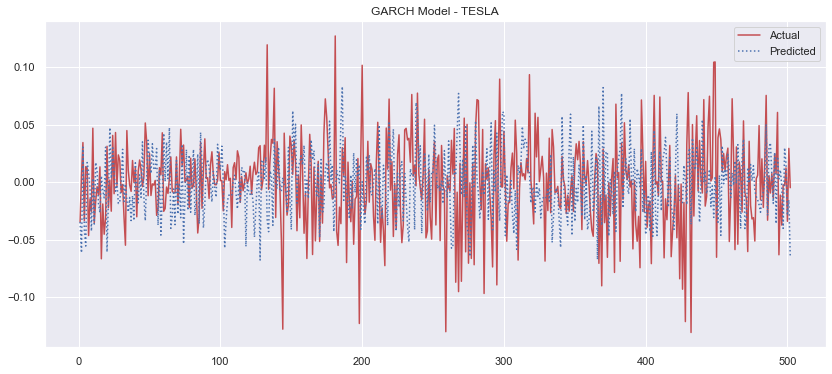

In [8]:
Y = np.diff(np.log(tesla['Adj Close'].values))
T = Y.size;

param0 = np.array([np.mean(Y), np.var(Y)/3, 0.2, 0.2])
param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
Y_GARCH = GARCH_Prod(param_star.x, Y[0], T)
timevec = np.linspace(1,T,T)

fig = plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')

plt.legend(loc='upper right')
plt.title("GARCH Model - TESLA")
plt.show()

In [13]:
RMSE = np.sqrt(np.mean((Y_GARCH - Y)**2))
print('RMSE values is:', RMSE)

RMSE values is: 0.04674422331575318
